In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit

import time

import numpy as onp
from numpy import genfromtxt

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import scipy.special as ss
import scipy.signal as sig
import scipy.interpolate as interp
import scipy.optimize

In [3]:
# general work flow
# read in CSV file
mcsollist = []
numtraj = 50
for i in range(1,1+numtraj):
    mcsollist.append(genfromtxt('./gausspot/mcsolgauss'+str(i)+'.csv',delimiter=','))

allmcsol = np.stack(mcsollist)
print(allmcsol.shape)

(50, 401)


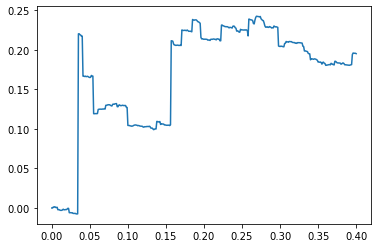

In [4]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.001

# time vector
tvec = np.arange(allmcsol[0].shape[0])*h

plt.plot(tvec, allmcsol[0])
plt.show()

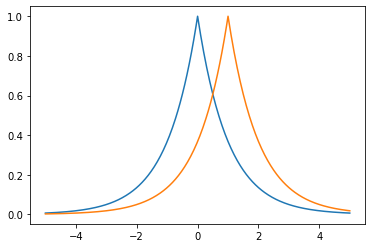

In [5]:
npts = 1601
lmax = 800

# simple way
uvec = np.linspace(-lmax, lmax, npts)
du = 2.0*lmax/(npts-1)

# LAPLACE because we don't take derivatives of xi in this code
@jit
def xi(u):
    return np.exp(-(np.abs(u)))

# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))
plt.show()

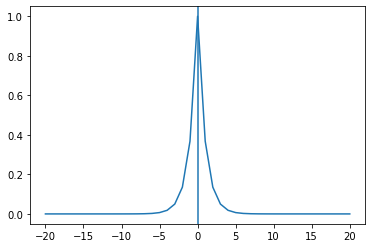

In [6]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)

# sanity check
plt.plot(uvec[780:821],xi(udiffmat)[780:821,800])
plt.axvline(x=0)
plt.show()


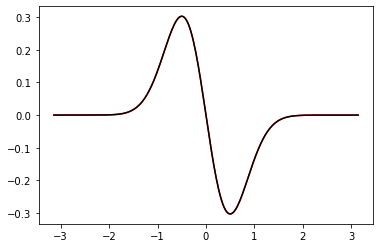

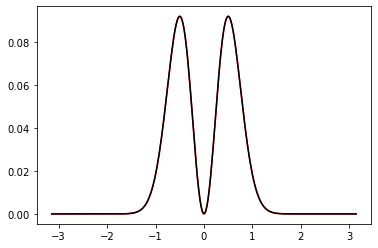

In [7]:
# set up true Fourier coefficients
JJ = 10
truecoefs = onp.zeros(2*JJ+1, dtype=onp.complex128)
L = 1
for j in range(-JJ, JJ+1):
    truecoefs[j+JJ] = 4*L*onp.exp(-onp.pi*(1j*j + 2*L**2*onp.pi))*(onp.exp(2j*j*onp.pi)-1)
    prefac = 1j*onp.exp(-j**2/(8*L**2))*j*onp.sqrt(2*onp.pi)
    truecoefs[j+JJ] += prefac*ss.erf((1j*j - 4*L**2*onp.pi)/(2*L*onp.sqrt(2)))
    truecoefs[j+JJ] -= prefac*ss.erf((1j*j + 4*L**2*onp.pi)/(2*L*onp.sqrt(2)))
    truecoefs[j+JJ] /= (-32*L**2*onp.pi)

# check whether these coefficients work for f(x)
xmax = L*onp.pi
xpts = 256
xvec = onp.linspace(-xmax, xmax, xpts)
testfn = onp.zeros(xpts, dtype=onp.complex128)
for j in range(-JJ, JJ+1):
    testfn += truecoefs[j+JJ]*onp.exp(1j*j*xvec/L)

plt.plot(xvec, onp.real(testfn), color='red')
plt.plot(xvec, -xvec*onp.exp(-2*xvec**2), color='black')
plt.show()

# check whether these coefficients work for f^2(x)
# note convolution below
testfn = onp.zeros(xpts, dtype=onp.complex128)
for k in range(-2*JJ, 2*JJ+1):
    thiscoef = 0
    for j in range(-JJ, JJ+1):
        if onp.abs(k-j) <= JJ:
            thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
    testfn += thiscoef*onp.exp(1j*k*xvec/L)

plt.plot(xvec, onp.real(testfn), color='red')
plt.plot(xvec, (xvec**2)*onp.exp(-4*xvec**2), color='black')
plt.show()

In [152]:
# return a complex coefficient vector from the concatenation of [real, imag] parts
def real2cplx(theta):
    coefs = np.concatenate([np.flipud(theta[1:(JJ+1)]), theta[:(JJ+1)]])
    coefs += np.concatenate([-1j*np.flipud(theta[(JJ+1):]),np.array([0.]),1j*theta[(JJ+1):]])
    return coefs

# much simpler approach?
lam = 0.0001
def simloglik(theta):
    coefs = real2cplx(theta)
    loglik = 0
    JJvec = np.arange(-JJ,JJ+1)
    for i in range(numtraj):
        mcsol = allmcsol[i,:]
        # convert theta into Fourier coefficients
        # compute Fourier series approx to f(y) at each of the data points
        fmat = np.exp(1j * np.outer( mcsol[:-1], JJvec )/L)
        fvec = fmat @ coefs
        psimat1 = np.exp(1j * np.outer( uvec, mcsol[:-1] + h*fvec ))
        psimat2 = np.exp(-h*np.abs(g*np.outer(uvec, np.ones(mcsol[:-1].shape)))**alpha)
        psimat = psimat1 * psimat2
        invfmat = np.exp(-1j * np.outer( mcsol[1:], uvec))
        allpdfs = np.real( du*np.einsum('ij,ji->i',invfmat,psimat) / (2.0/np.pi) )
        corpdfs = allpdfs * (allpdfs > 0) + 1e-10 * (allpdfs <= 0)
        loglik += np.mean(np.log(corpdfs))
    
    loglik -= lam*np.sum(np.abs(coefs*JJvec**2)**2)
    # loglik -= lam*np.sum(np.abs(np.diff(coefs,1))**2)
    # loglik -= lam*np.sum(np.abs(np.diff(coefs,2))**2)
    return loglik

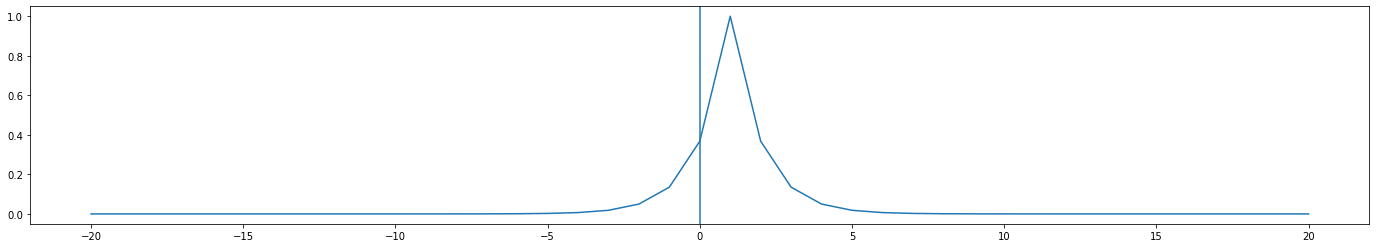

In [153]:
testcoef = onp.zeros(npts)
testcoef[801] = 1.0
plt.figure(figsize=(24,4))
plt.plot(uvec[780:821], (xi(udiffmat) @ testcoef)[780:821])
plt.axvline(0)

In [144]:
jsimloglik = jit(simloglik)
gradsll = jit(grad(simloglik))

def nll(x):
    return -onp.array( jsimloglik(x) ).item()

def gnll(x):
    return -onp.array( gradsll(x) )

In [154]:
# print(truecoefs)
onp.array( jsimloglik(np.concatenate([ np.real(truecoefs[JJ:]), np.imag(truecoefs[JJ+1:])])) ).item()
print( gradsll(np.concatenate([ np.real(truecoefs[JJ:]), np.imag(truecoefs[JJ+1:])])) )

[-4.6356926  -9.21357903 -9.08787614 -8.96647323 -8.88250172 -8.84540241
 -8.83903018 -8.85779197 -8.92878749 -9.02655864 -9.06930666  0.38343753
  0.66306001  0.7824964   0.7858096   0.73467314  0.63917894  0.52417981
  0.44124532  0.43496238  0.53582242]


In [ ]:
thetarand = onp.concatenate([ onp.real(truecoefs[JJ:]), onp.imag(truecoefs[JJ+1:])])
thetarand = onp.array(thetarand)
test = scipy.optimize.minimize(fun=nll,jac=gnll,x0=thetarand,method='trust-constr',options={'verbose':2})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -3.3906e+02 | 1.00e+00 | 9.21e+00 | 0.00e+00 |
|   2   |   2   |   1   | -3.3906e+02 | 1.00e-01 | 9.21e+00 | 0.00e+00 |
|   3   |   3   |   2   | -3.3906e+02 | 5.00e-02 | 9.21e+00 | 0.00e+00 |
|   4   |   4   |   3   | -3.3906e+02 | 2.50e-02 | 9.21e+00 | 0.00e+00 |
|   5   |   5   |   4   | -3.3906e+02 | 1.25e-02 | 9.21e+00 | 0.00e+00 |
|   6   |   6   |   5   | -3.3906e+02 | 6.25e-03 | 9.21e+00 | 0.00e+00 |
|   7   |   7   |   6   | -3.3919e+02 | 1.25e-02 | 1.20e+00 | 0.00e+00 |
|   8   |   8   |   8   | -3.3937e+02 | 8.75e-02 | 1.63e+01 | 0.00e+00 |
|   9   |   9   |  11   | -3.3937e+02 | 4.38e-02 | 1.63e+01 | 0.00e+00 |
|  10   |  10   |  14   | -3.3950e+02 | 2.24e-01 | 1.19e+01 | 0.00e+00 |
|  11   |  11   |  18   | -3.3950e+02 | 4.46e-02 | 1.19e+01 | 0.00e+00 |
|  12   |  12   |  21   | -3.3950e+02 | 2.23e-02 | 

In [ ]:
test.x.shape

In [ ]:
# stepsize = 1e-10
# maxsteps = 1000
# for i in range(maxsteps):
#     thisgrad = gradsll(thetarand)
#     thetarand += stepsize*thisgrad
#     if i % 10 == 0:
#         ll = jsimloglik(thetarand)
#         print(ll, np.linalg.norm(thisgrad))
#         if np.linalg.norm(thisgrad) < 10:
#             break

In [ ]:
estcoefs = real2cplx(test.x)
xmax = L*onp.pi
xpts = 256
xvec = onp.linspace(-xmax, xmax, xpts)
testfn = onp.zeros(xpts, dtype=onp.complex128)
for j in range(-JJ, JJ+1):
    testfn += estcoefs[j+JJ]*onp.exp(1j*j*xvec/L)

plt.plot(xvec, onp.real(testfn), color='red')
plt.plot(xvec, -xvec*onp.exp(-2*xvec**2), color='black')
plt.show()

In [150]:
estcoefs

DeviceArray([-0.00458124+0.00276603j, -0.00666356+0.00321545j,
             -0.00593346+0.00400678j, -0.00232083+0.00138333j,
              0.00067561-0.0078941j , -0.00030507-0.02171721j,
             -0.00560331-0.03557496j, -0.00959656-0.05161377j,
             -0.00198011-0.07782233j,  0.02700496-0.10302215j,
             -0.03331678+0.j        ,  0.02700496+0.10302215j,
             -0.00198011+0.07782233j, -0.00959656+0.05161377j,
             -0.00560331+0.03557496j, -0.00030507+0.02171721j,
              0.00067561+0.0078941j , -0.00232083-0.00138333j,
             -0.00593346-0.00400678j, -0.00666356-0.00321545j,
             -0.00458124-0.00276603j], dtype=complex128)

In [151]:
truecoefs

array([-0.-1.85829487e-06j, -0.-1.79818100e-05j, -0.-1.33830129e-04j,
       -0.-7.63597448e-04j, -0.-3.32388623e-03j, -0.-1.09551879e-02j,
       -0.-2.69954832e-02j, -0.-4.85690984e-02j, -0.-6.04926811e-02j,
       -0.-4.40081659e-02j, -0.-0.00000000e+00j, -0.+4.40081659e-02j,
       -0.+6.04926811e-02j, -0.+4.85690984e-02j, -0.+2.69954832e-02j,
       -0.+1.09551879e-02j, -0.+3.32388623e-03j, -0.+7.63597448e-04j,
       -0.+1.33830129e-04j, -0.+1.79818100e-05j, -0.+1.85829487e-06j])

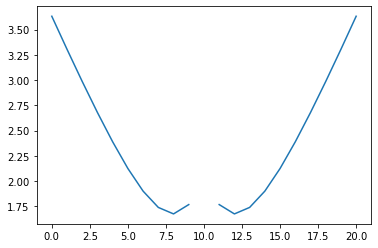

In [96]:
plt.plot(np.sqrt(-np.log(np.abs(truecoefs))))